### Laboratorium 4 - zadania

In [1]:
import os

import cv2
import numpy as np
import matplotlib.pyplot as plt
from skimage.segmentation import mark_boundaries, slic

#### Zadanie 1

Dane są obrazy `tabby` i `pills`. Wykonaj dla nich segmentację przy użyciu algorytmu SLIC. Celem jest uzyskanie **jednolitych**  superpikseli, a więc zawierających tylko fragmenty obiektów lub tylko tła (a nie jednego i drugiego naraz). Przeanalizuj zachowanie algorytmu dla różnej liczby superpikseli i parametru sigma.

Zwróć uwagę, że wynikiem działania scikitowej implementacji SLIC - [`skimage.segmentation.slic`](https://scikit-image.org/docs/stable/api/skimage.segmentation.html#skimage.segmentation.slic) - (podobnie jak wielu innych algorytmów klasyfikacyjnych) jest obraz typu `np.int64` przyporządkowujący każdemu pikselowi obrazu wejściowego indeks superpiksela. Takiej reprezentacji oczekuje też funkcja [`mark_boundaries`](https://scikit-image.org/docs/stable/api/skimage.segmentation.html#skimage.segmentation.mark_boundaries).

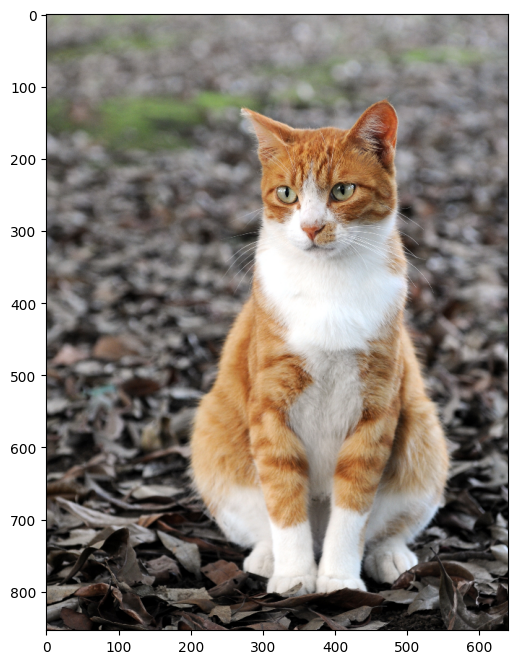

In [2]:
_ = cv2.imread('tabby.jpg')[..., ::-1]
tabby = cv2.resize(_, dsize=None, fx=0.3, fy=0.3)
plt.subplots(1,1,figsize=(8,8))[1].imshow(tabby);

In [3]:
def slic_segments_comparison(img, n_segments_list, sigma = 10):
    _, axs = plt.subplots(len(n_segments_list) // 3 + 1, 3, figsize = (15, 5 * len(n_segments_list) // 3 + 1))
    axs[0][0].imshow(img)
    axs[0][0].axis('off')
    axs[0][0].set_title('Original image')

    for i, n in enumerate(n_segments_list):
        segments = slic(img, n_segments = n, sigma = sigma)
        axs[(i + 1) // 3][(i + 1) % 3].imshow(mark_boundaries(img, segments, color = (1, 0, 0)))
        axs[(i + 1) // 3][(i + 1) % 3].axis('off')
        axs[(i + 1) // 3][(i + 1) % 3].set_title(f'n_segments = {n}')
    plt.suptitle(f'sigma = {sigma}', fontsize = 20)
    plt.show()


def slic_sigma_comparison(img, n_sigma_list, n_segments = 300):
    _, axs = plt.subplots(len(n_sigma_list) // 3 + 1, 3, figsize = (15, 5 * len(n_sigma_list) // 3 + 1))
    axs[0][0].imshow(img)
    axs[0][0].axis('off')
    axs[0][0].set_title('Original image')

    for i, s in enumerate(n_sigma_list):
        segments = slic(img, n_segments = n_segments, sigma = s)
        axs[(i + 1) // 3][(i + 1) % 3].imshow(mark_boundaries(img, segments, color = (1, 0, 0)))
        axs[(i + 1) // 3][(i + 1) % 3].axis('off')
        axs[(i + 1) // 3][(i + 1) % 3].set_title(f'sigma = {s}')
    plt.suptitle(f'n_segments = {n_segments}', fontsize = 20)
    plt.show()

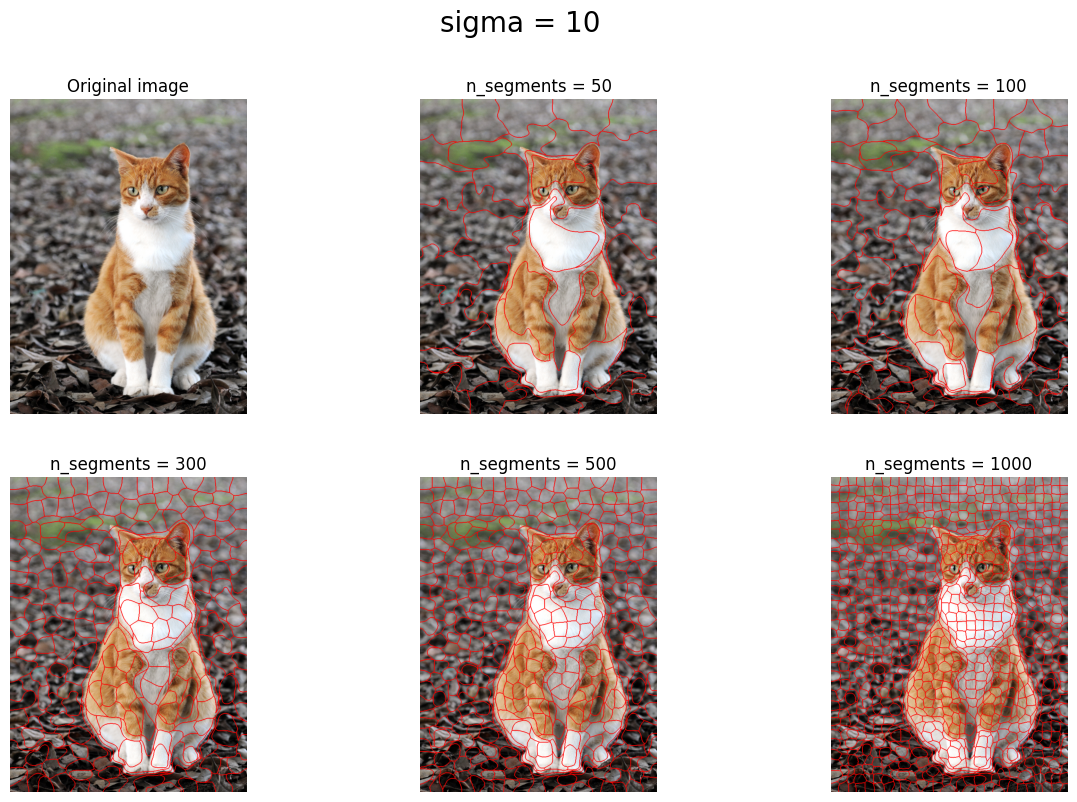

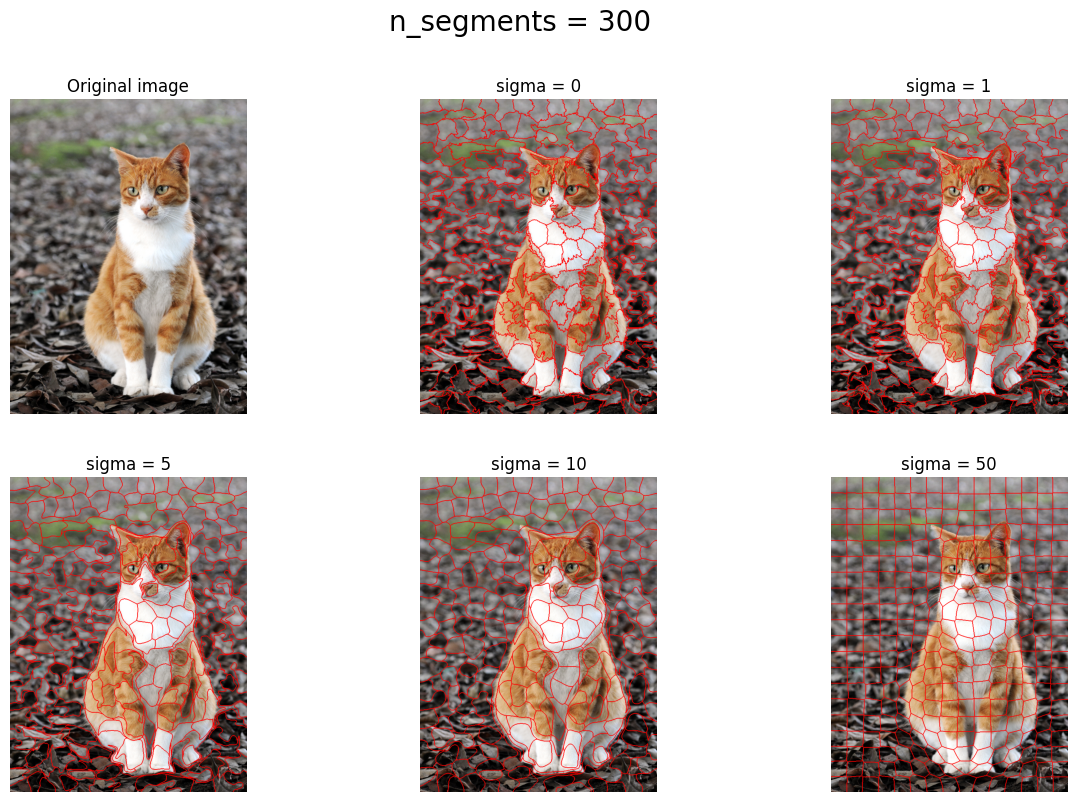

In [4]:
slic_segments_comparison(tabby, [50, 100, 300, 500, 1000])
slic_sigma_comparison(tabby, [0, 1, 5, 10, 50])

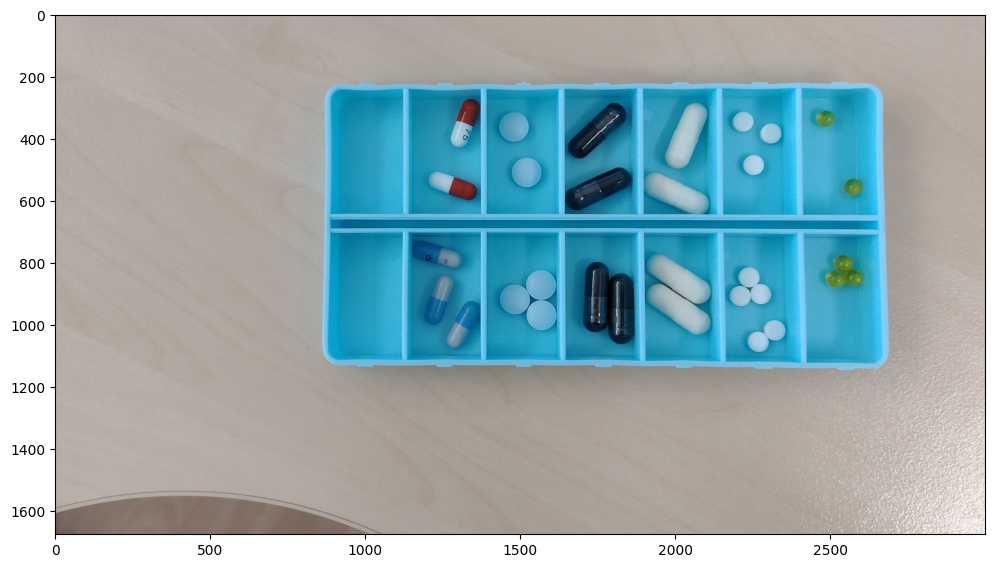

In [5]:
pills = cv2.imread('pills.png')[..., ::-1]
plt.subplots(1,1,figsize=(12,8))[1].imshow(pills);

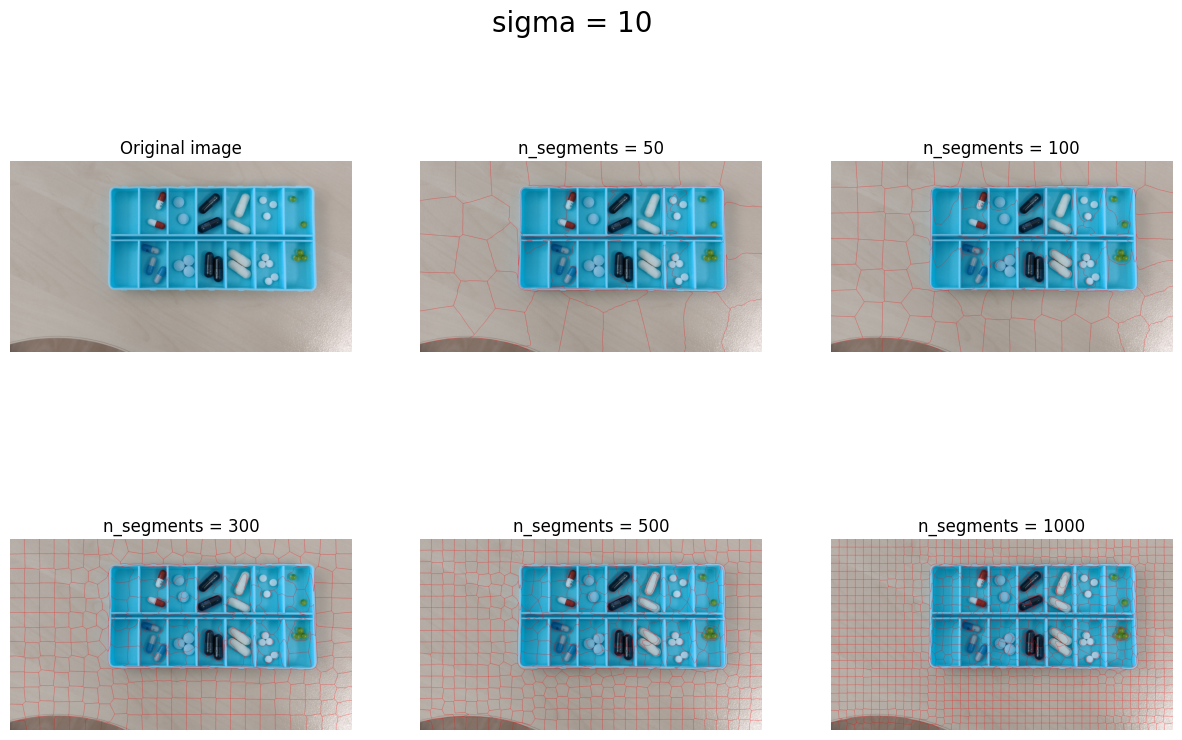

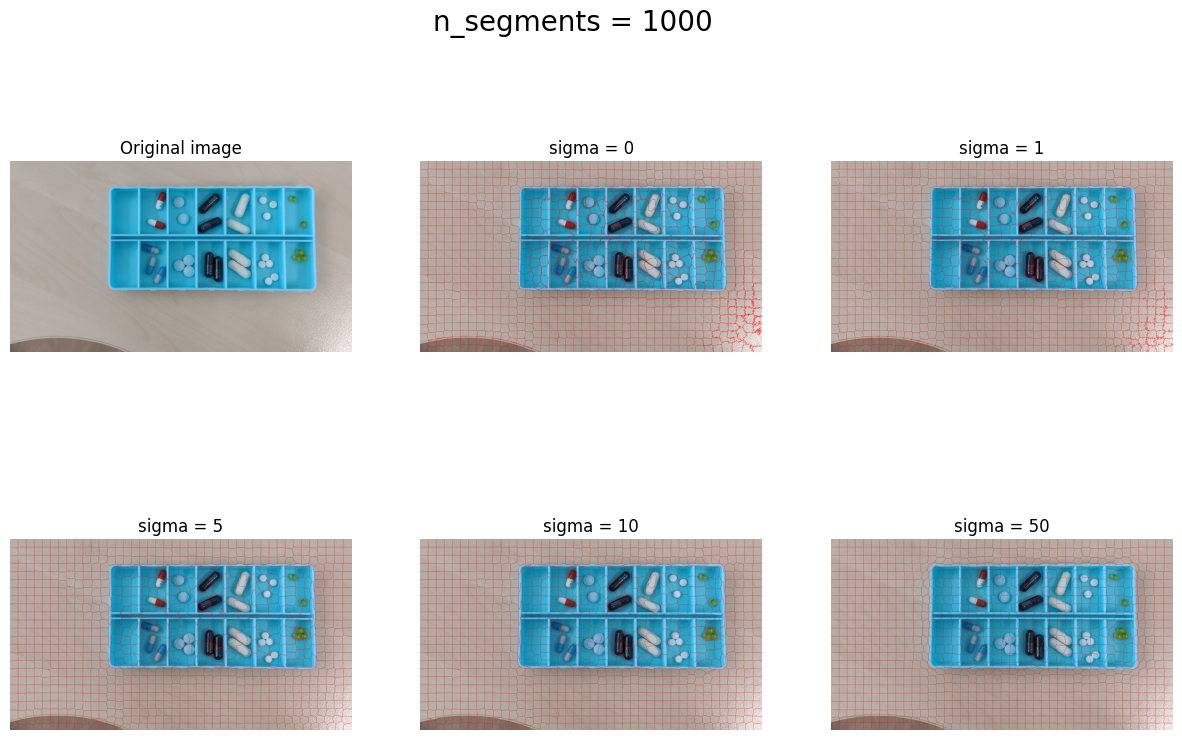

In [6]:
slic_segments_comparison(pills, [50, 100, 300, 500, 1000])
slic_sigma_comparison(pills, [0, 1, 5, 10, 50], n_segments = 1000)

#### Zadanie 2

Dla obrazu `tabby` wykonaj post-processing segmentacji SLIC by uzyskać dwa jednorodne obszary: jeden zawierający wyłącznie kota, drugi zawierający wyłącznie tło.

Można to zadanie potraktować jako binaryzację na poziomie superpikseli i zrealizować je za pomocą progowania. 
Można też potraktować je jako klasteryzację superpikseli i wykorzystać np. [`cv2.kmeans`](https://docs.opencv.org/4.x/d5/d38/group__core__cluster.html#ga9a34dc06c6ec9460e90860f15bcd2f88).  
Niezależnie od wybranej ścieżki, konieczne będzie opisanie każdego z superpikseli za pomocą jakiejś *cechy* go opisującej (lub kilku cech). Najprostszymi cechami mogą być np. średnie wartości składowych barwy pikseli wchodzących w skład superpiksela.  
Do zastanowienia: jakie parametry SLICa wybrać jako podstawę w tym zadaniu?

Zaprezentuj wyniki albo za pomocą `mark_boundaries` albo wyświetlając maskę binarną.

---

NumPy pro-tip: aby uzyskać zbiór wszystkich pikseli obrazu o wartości np. 3 możesz użyć notacji: ```obraz==3```. Wynikiem jest macierz boolowska, której można używać jako selektor. Np. aby na obrazie `A` wyzerować wszystkie piksele, którym w obrazie `B` odpowiada wartość 5, możesz napisać:  
```A[B==5] = 0```  
Ten zapis jest **znacznie** szybszy niż manualne iterowanie po obrazach i sprawdzanie warunków if-ami.

---

Przykładowe użycie `cv2.kmeans` (więcej możesz poczytać np. [tutaj](https://opencv24-python-tutorials.readthedocs.io/en/latest/py_tutorials/py_ml/py_kmeans/py_kmeans_opencv/py_kmeans_opencv.html)):
```python
c, labels, centers = cv2.kmeans(
    data=data,  # np.ndarray typu float o wymiarach NxK gdzie N to liczba sampli (u nas: superpikseli), K - liczba cech
    K=2,        # oczekiwana liczba klastrów
    bestLabels=None,
    criteria=(cv2.TERM_CRITERIA_EPS, 10, 1.0),  # przykładowe kryteria stopu
    attempts=1, # liczba powtórzeń algorytmu
    flags=cv2.KMEANS_RANDOM_CENTERS  # sposób inicjalizacji klastrów
)
```

Funkcja ta zwraca krotkę, której najważniejszym komponentem jest ten drugi (tu: `labels`), tj. macierz o wymiarach Nx1, zawierająca indeks klastra przypisanego i-temu samplowi.

In [7]:
# zacznij od przygotowania macierzy wejściowej (data) reprezentującej superpiksele jako punkty danych

In [122]:
def superpixels_matrix(img, n_segments = 500, sigma = 10):
    segments = slic(img, n_segments = n_segments, sigma = sigma) # segmenty
    pixels = np.zeros(img.shape) # obraz wyjściowy
    centroids = np.zeros((n_segments, 2)) # lista centroidów
    mean_colors = np.zeros((n_segments, 3)) # lista uśrednionych kolorów centroidów
    
    for i, segment in enumerate(np.unique(segments)):
        # UŚREDNIANIE KOLORU W SEGMENTACH
        mask = segments == segment
        only_segment_pixels = img[mask]
        mean_color = only_segment_pixels.mean(axis = 0).round(0).astype(np.uint8)
        mean_colors[i] = mean_color # lista uśrednionych kolorów w segmentach
        pixels[segments == segment] = only_segment_pixels.mean(axis = 0)
        pixels = pixels.astype(np.uint8) # obrazek z uśrednionymi kolorami
        # CENTROIDY
        only_segment_coords = np.column_stack(np.where(segments == segment))
        centroids[i] = only_segment_coords.mean(axis = 0)
        
    return pixels, list(zip(np.unique(segments), centroids, mean_colors))

In [123]:
img, mat = superpixels_matrix(tabby)

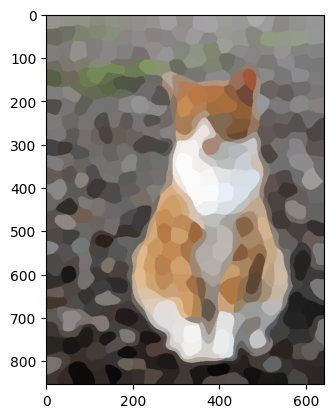

In [124]:
plt.imshow(img)

In [125]:
mat

[(np.int64(1), array([16.08966148, 15.67795059]), array([149., 149., 140.])),
 (np.int64(2), array([14.03235908, 49.42484342]), array([147., 146., 139.])),
 (np.int64(3), array([12.67084639, 84.50574713]), array([145., 149., 135.])),
 (np.int64(4), array([ 12.95881007, 117.22997712]), array([139., 141., 129.])),
 (np.int64(5), array([ 13.99130435, 151.08804348]), array([142., 146., 134.])),
 (np.int64(6), array([ 17.79130435, 182.4373913 ]), array([143., 141., 135.])),
 (np.int64(7), array([ 19.13935075, 214.26682502]), array([147., 144., 141.])),
 (np.int64(8), array([ 15.81755424, 246.22485207]), array([149., 147., 145.])),
 (np.int64(9), array([ 16.96216617, 280.56973294]), array([161., 158., 159.])),
 (np.int64(10),
  array([ 14.70812183, 320.31979695]),
  array([146., 142., 143.])),
 (np.int64(11),
  array([ 17.40525739, 351.61883899]),
  array([164., 162., 165.])),
 (np.int64(12),
  array([ 22.06912442, 378.58986175]),
  array([166., 164., 164.])),
 (np.int64(13),
  array([ 13.67

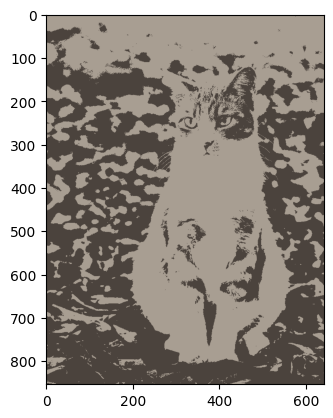

In [10]:
tabby2 = np.float32(tabby.reshape(-1, 3))
K = 2
criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 100, 0.2)
attempts = 10
flags = cv2.KMEANS_RANDOM_CENTERS

retval, labels, centers = cv2.kmeans(tabby2, K, None, criteria, attempts, flags)
centers = np.uint8(centers)
segmented_image = centers[labels.flatten()]
segmented_image = segmented_image.reshape(tabby.shape)
plt.imshow(segmented_image)
